# Week 3 Exercise: kernel SVM

Advanced Machine Learning for KCS



-------------------------------------------------------------------------------

*The goal is to implement and evaluate different kernels for SVMs for one dataset.*
*We start by importing the necessary libraries.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
import pandas as pd
import seaborn as sns

# this code is only for suppressing a very specific warning
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')

#### Creating dataset

We generate our random dataset; this will be 2D data that is not linearly separable. In fact, the data will follow concentric rings.

In [2]:
N = 200 # number of samples
c = 0.5 # scale factor between inner and outer circles
noise = 0.1 # noise parameter

# generate data
x_vals, t_vals = datasets.make_circles(n_samples=N, factor=c, noise=noise)
# if a value in y_vals is 1, we leave it at one, but if it is 0, we set it to -1
t_vals = np.where(t_vals, 1, -1)

class1_idxs = np.flatnonzero(t_vals == 1)
class1_x = x_vals[class1_idxs]
class1_t = t_vals[class1_idxs]
class2_idxs = np.flatnonzero(t_vals == -1)
class2_x = x_vals[class2_idxs]
class2_t = t_vals[class2_idxs]

We can take a quick look at our data to get a sense of what we're trying to predict.

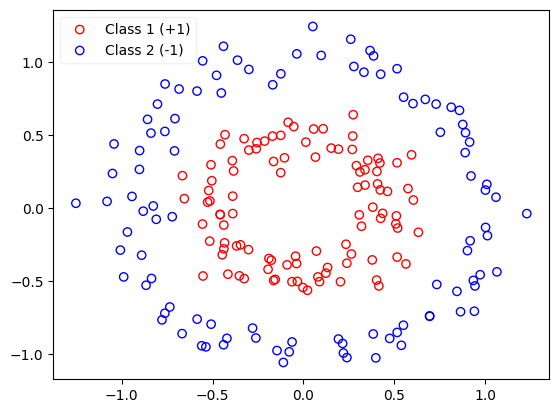

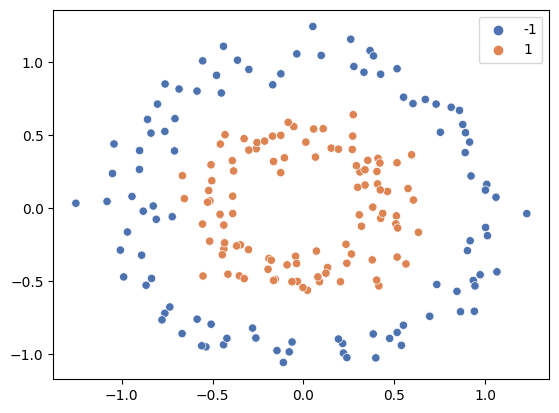

In [3]:
# matplotlib:
plt.scatter(class1_x[:, 0], class1_x[:, 1],
            label = "Class 1 (+1)",
            color = "none",
            edgecolor = "red"
           )
plt.scatter(class2_x[:, 0], class2_x[:, 1],
            label = "Class 2 (-1)",
            color = "none",
            edgecolor = "blue"
           )
plt.legend(loc="upper left", framealpha=0.25)
plt.show()
# simpler with seaborn:
plot_raw = sns.scatterplot(x=x_vals[:,0], y=x_vals[:, 1],
                           hue=t_vals, palette="deep")

## Task:
### (a)
*Implement:*
* *a linear kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = \mathbf{x}_1^\intercal \mathbf{x}_2$
* *a Gaussian or radial basis function (RBF) kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = e^{(-\gamma \|\mathbf{x}_1 - \mathbf{x}_2 \|^2)}$
* *a polynomial kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = (\mathbf{x}_1^\intercal \mathbf{x}_2 + c)^d$

#### Here can can write your solution:

In [9]:
type='linear'

def my_kernel(x, t):
    #x is matrix over all dimensions x1, x2, ...
    x1 = x[:, 0]
    x2 = x[:,1]
    kernel = None
    if type=='linear':
        # linear kernel
        kernel = x1.T @ x2
        #kernel = None  #remove

    elif type=='gaussian':
        # Gaussian (RBF) kernel
        gamma = 0.2
        x1_norm = np.sum(x1 ** 2, axis=-1)
        x2_norm = np.sum(x2 ** 2, axis=-1)
        kernel = np.exp(-gamma * (x1_norm[:, None] + x2_norm[None, :] - 2 * x1 @ x2))
        #kernel = None  #remove


    elif type=='polynomial':
        # polynomial kernel
        c = 0.3
        d = 2
        kernel = (x1.T @ x2 + c)**d
        #kernel = None  #remove

    return kernel

In [12]:

my_kernel(x_vals, t_vals)

-1.1828304775983183

#### Perform optimisation of the SVM via a manual iteration

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function
We start the training loop for the SVM.  We will randomly choose a batch of points and run the train step.  Then we calculate the loss and accuracy.

In [10]:
# set up the SVM model
# we use max_iter=1 so that we can iterate manually below
clf = svm.SVC(kernel=my_kernel, max_iter=1, tol=0.001)
batch_size = N  # we start with a batch size equal of the dataset size, but we can try out smaller ones!
epochs = 10000

# training loop
temp_losses = []
batch_accs = []
np.random.seed(0) # set this for your experiments to compare the different kernels
for i in range(epochs):
    # generate random indices equal to batch_size
    batch_idxs = np.random.choice(N, size=batch_size)
    # get the corresponding input and target points
    batch_x = x_vals[batch_idxs]
    batch_t = t_vals[batch_idxs][:,]
    #print(np.shape(batch_x), np.shape(batch_t))

    # train the model with this batch
    clf.fit(batch_x, batch_t)

    # calculate temporary train accuracy
    accuracy = clf.score(batch_x, batch_t)
    batch_accs.append(accuracy)

    if (i+1)%1000==0:
        print("Step #{}".format(i+1))
        print("Accuracy = ", accuracy)

IndexError: tuple index out of range

*To plot a pretty picture of the regions we fit, we create a fine mesh to run through our model and get the predictions.*

In [13]:
# find boundaries for contour plot
abscissa_min, abscissa_max = x_vals[:, 0].min()-1, x_vals[:, 0].max()+1
ordinate_min, ordinate_max = x_vals[:, 1].min()-1, x_vals[:, 1].max()+1

# generate mesh grid of points
#h = .025  # step size in the mesh
#xx, yy = np.meshgrid(np.arange(abscissa_min, abscissa_max, h), np.arange(ordinate_min, ordinate_max, h))
xx, yy = np.meshgrid(
    np.linspace(abscissa_min, abscissa_max, 10),
    np.linspace(ordinate_min, ordinate_max, 20)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]
print(np.shape(grid_points))

print(xx)
print(yy)
grid_preds = clf.predict(grid_points)  # this is not a clean way to do and will raise a warning (we only process values here, but trained with dataframes that had names), but for our purpose that's fine
grid_preds = grid_preds.reshape(xx.shape)


(200, 2)
[[-2.25189179 -1.75409167 -1.25629154 -0.75849142 -0.26069129  0.23710883
   0.73490896  1.23270908  1.73050921  2.22830933]
 [-2.25189179 -1.75409167 -1.25629154 -0.75849142 -0.26069129  0.23710883
   0.73490896  1.23270908  1.73050921  2.22830933]
 [-2.25189179 -1.75409167 -1.25629154 -0.75849142 -0.26069129  0.23710883
   0.73490896  1.23270908  1.73050921  2.22830933]
 [-2.25189179 -1.75409167 -1.25629154 -0.75849142 -0.26069129  0.23710883
   0.73490896  1.23270908  1.73050921  2.22830933]
 [-2.25189179 -1.75409167 -1.25629154 -0.75849142 -0.26069129  0.23710883
   0.73490896  1.23270908  1.73050921  2.22830933]
 [-2.25189179 -1.75409167 -1.25629154 -0.75849142 -0.26069129  0.23710883
   0.73490896  1.23270908  1.73050921  2.22830933]
 [-2.25189179 -1.75409167 -1.25629154 -0.75849142 -0.26069129  0.23710883
   0.73490896  1.23270908  1.73050921  2.22830933]
 [-2.25189179 -1.75409167 -1.25629154 -0.75849142 -0.26069129  0.23710883
   0.73490896  1.23270908  1.73050921  2.2

AttributeError: 'SVC' object has no attribute 'support_vectors_'

*Then we make the plot of our points and our decision boundary.*

/Users/emilykruger/opt/anaconda3/envs/py11/lib/python3.11/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


NameError: name 'grid_preds' is not defined

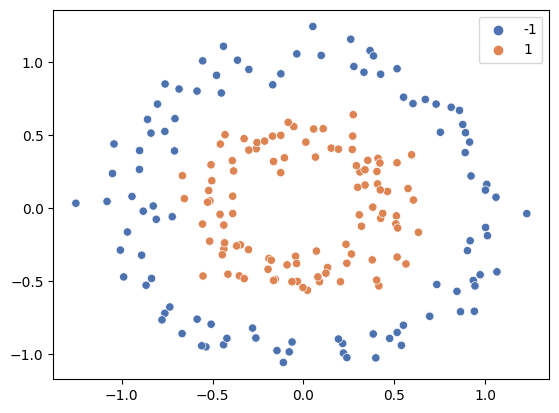

In [14]:
plot_rsk = sns.scatterplot(x=x_vals[:,0], y=x_vals[:,1],
                           hue=t_vals, cmap=plt.cm.Paired, palette="deep")
plot_rsk.pcolormesh(xx, yy, grid_preds, cmap=plt.cm.Paired, alpha=0.1)

We can also plot the accuracy over the training batches:

<Axes: >

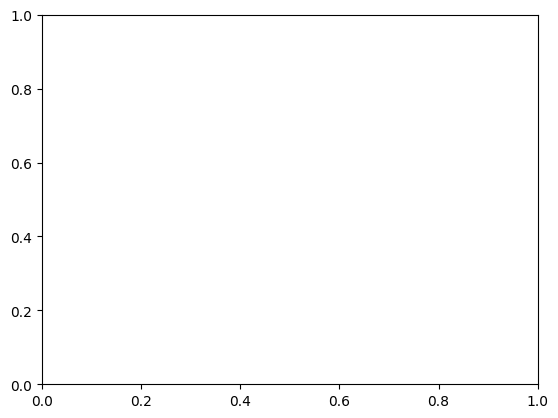

In [15]:
batch_accs_pd = pd.DataFrame({'Batch': [k for k in range(len(batch_accs))], 'Accuracy': batch_accs})
sns.lineplot(data=batch_accs_pd, x="Batch", y="Accuracy")

## Task:
### (b)
*Which of these performs best on the data, in terms of speed and quality? Do not forget to set the random seed to receive reproducible results.*

### (c)
*Test different values of $c$ and $d$ for the polynomial kernel. Which of them work best?*

### (d)
*Test different values of $\gamma$ for the RBF kernel. Which of them works best?*

### (e)
*Change the part of the code which generates the data such that it becomes linearly separable.*

### (f)
*Re-evaluate the three kernels. Do you get the same result?*